Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 128)         0

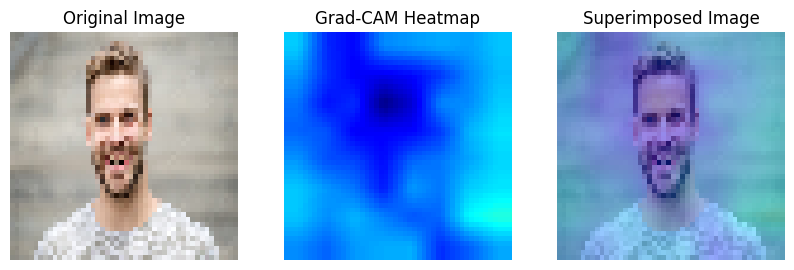

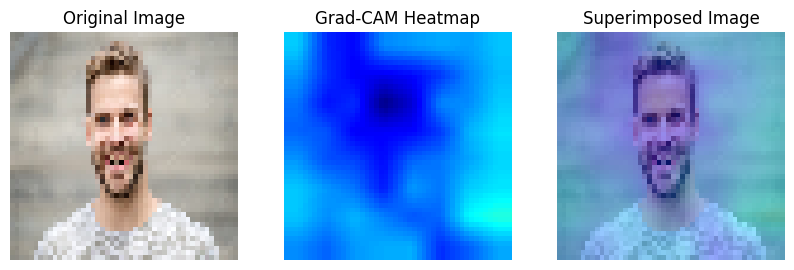

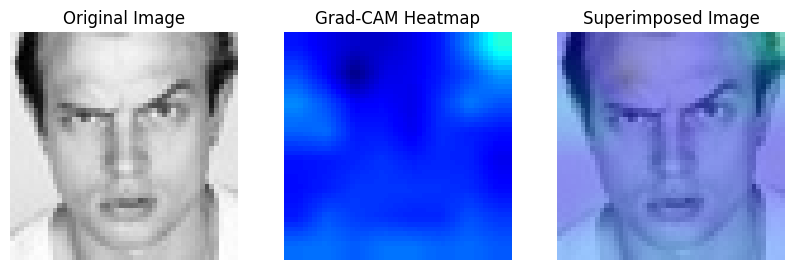

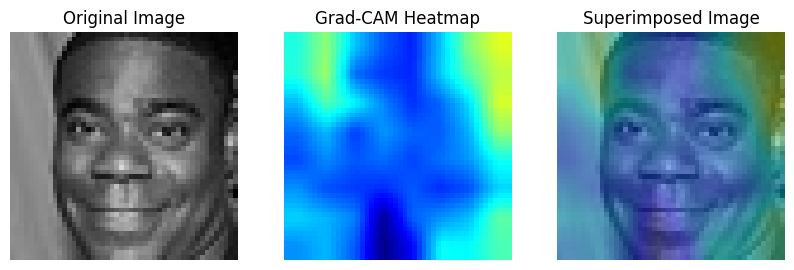

In [1]:
### Step 1: Import Required Libraries
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import cv2
import tkinter as tk
from tkinter import filedialog, Label, Button
from PIL import Image, ImageTk

### Step 2: Define and Compile the Model
# Create a simple CNN model for emotion detection
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')  # Assuming 7 classes for FER 2013
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Display model summary
model.summary()

### GUI Setup
class GradCamApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Emotion Detection - Grad-CAM Visualization")

        # UI Elements
        self.label = Label(self.root, text="Upload an Image", font=("Arial", 14))
        self.label.pack(pady=10)

        self.upload_button = Button(self.root, text="Upload Image", command=self.upload_image, font=("Arial", 12))
        self.upload_button.pack(pady=5)

        self.image_label = Label(self.root)
        self.image_label.pack(pady=10)

        self.analyze_button = Button(self.root, text="Analyze Image", command=self.analyze_image, font=("Arial", 12))
        self.analyze_button.pack(pady=10)

        self.result_label = Label(self.root, text="", font=("Arial", 14))
        self.result_label.pack(pady=10)

        self.file_path = None

    def upload_image(self):
        self.file_path = filedialog.askopenfilename()
        if self.file_path:
            img = Image.open(self.file_path)
            img = img.resize((200, 200))
            img_tk = ImageTk.PhotoImage(img)
            self.image_label.configure(image=img_tk)
            self.image_label.image = img_tk

    def analyze_image(self):
        if not self.file_path:
            self.result_label.config(text="Please upload an image first.")
            return

        # Preprocess Image
        img = cv2.imread(self.file_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (48, 48))
        img = img / 255.0
        img = np.expand_dims(img, axis=-1)
        img = np.expand_dims(img, axis=0)

        # Get Grad-CAM Heatmap
        layer_name = 'conv2d_2'  # Adjust based on model
        grad_model = tf.keras.models.Model(inputs=model.inputs, outputs=[model.get_layer(layer_name).output, model.output])
        with tf.GradientTape() as tape:
            conv_outputs, predictions = grad_model(img)
            loss = predictions[:, np.argmax(predictions[0])]

        grads = tape.gradient(loss, conv_outputs)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        conv_outputs = conv_outputs[0]
        heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

        # Visualize Heatmap
        original_img = cv2.imread(self.file_path)
        original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
        original_img = cv2.resize(original_img, (48, 48))

        heatmap = cv2.resize(heatmap.numpy(), (original_img.shape[1], original_img.shape[0]))
        heatmap = np.uint8(255 * heatmap)
        heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap_color, 0.4, 0)

        # Display Results
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.title('Original Image')
        plt.imshow(original_img)
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title('Grad-CAM Heatmap')
        plt.imshow(heatmap_color)
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title('Superimposed Image')
        plt.imshow(superimposed_img)
        plt.axis('off')

        plt.show()
        self.result_label.config(text=f"Predicted Emotion: {np.argmax(predictions[0])}")

### Run GUI
if __name__ == "__main__":
    root = tk.Tk()
    app = GradCamApp(root)
    root.mainloop()
